In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models, layers
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [4]:
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

np.random.seed(3)
tf.random.set_seed(3)

In [5]:
# 생성자 모델
generator = models.Sequential()
generator.add(layers.Dense(7*7*128, input_dim = 100, activation = layers.LeakyReLU(0.2)))
generator.add(layers.BatchNormalization())
generator.add(layers.Reshape((7, 7, 128)))
generator.add(layers.UpSampling2D())
generator.add(layers.Conv2D(64, kernel_size = 5, padding = 'same'))
generator.add(layers.BatchNormalization())
generator.add(layers.Activation(layers.LeakyReLU(0.2)))
generator.add(layers.UpSampling2D())
generator.add(layers.Conv2D(1, kernel_size = 5, padding = 'same', activation = 'tanh'))

In [6]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)        0

In [7]:
# 판별자 모델
discriminator = models.Sequential()
discriminator.add(layers.Conv2D(64, kernel_size = 5, strides = 2, input_shape = (28, 28, 1), padding = 'same'))
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Conv2D(128, kernel_size = 5, strides = 2, padding = 'same'))
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Flatten()) # 1차원으로 펼치기
discriminator.add(layers.Dense(1, activation = 'sigmoid'))

In [8]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
activation_2 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [10]:
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam') # binary_crossentropy : 이진분류
discriminator.trainable = False # 판별자는 생성자 학습할때 같이 기본학습을 하지 못하게 막음

In [12]:
ginput = layers.Input(shape = (100,))
dis_output = discriminator(generator(ginput)) #노이즈를 생성자가 받고 판별자가 받는 것을 정의
gan = models.Model(ginput, dis_output)
gan.compile(loss = 'binary_crossentropy', optimizer = 'adam') 
gan.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [21]:
def gan_train(epoch, batch_size, saving_interval):
    (X_train, _), (_, _) = mnist.load_data() # X_train을 제외하고 나머지를 버리려고 언더바_를 쓴 것
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float)
    X_train = (X_train - 127.5) / 127.5
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for i in range(epoch):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx] #진짜 이미지
        d_loss_real = discriminator.train_on_batch(imgs, true) #진짜 이미지 학습(역전파, 파라미터 갱신 이루어짐)
        
        noise = np.random.normal(0, 1, (batch_size, 100)) # 최초에는 generator가 학습이 안된 상태
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # 생성자가 만들어낸 가짜이미지를 가짜라고 계속 훈련
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # generator 훈련, 오차를 줄이기 위한 학습
        g_loss = gan.train_on_batch(noise, true) # generator 훈련, gan network를 통과시킴
        
        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)        
        
        if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("gan_images/gan_mnist_%d.png" % i)

epoch:0  d_loss:0.6993  g_loss:0.7104
epoch:1  d_loss:0.7045  g_loss:0.6930
epoch:2  d_loss:0.7026  g_loss:0.6752
epoch:3  d_loss:0.7066  g_loss:0.6755
epoch:4  d_loss:0.7084  g_loss:0.6648
epoch:5  d_loss:0.7137  g_loss:0.6586
epoch:6  d_loss:0.7137  g_loss:0.6533
epoch:7  d_loss:0.7121  g_loss:0.6550
epoch:8  d_loss:0.7136  g_loss:0.6406
epoch:9  d_loss:0.7158  g_loss:0.6363
epoch:10  d_loss:0.7175  g_loss:0.6402
epoch:11  d_loss:0.7191  g_loss:0.6362
epoch:12  d_loss:0.7231  g_loss:0.6381
epoch:13  d_loss:0.7197  g_loss:0.6277
epoch:14  d_loss:0.7317  g_loss:0.6228
epoch:15  d_loss:0.7278  g_loss:0.6181
epoch:16  d_loss:0.7309  g_loss:0.6267
epoch:17  d_loss:0.7233  g_loss:0.6248
epoch:18  d_loss:0.7275  g_loss:0.6180
epoch:19  d_loss:0.7302  g_loss:0.6225
epoch:20  d_loss:0.7329  g_loss:0.6148
epoch:21  d_loss:0.7295  g_loss:0.6068
epoch:22  d_loss:0.7350  g_loss:0.6036
epoch:23  d_loss:0.7354  g_loss:0.6056
epoch:24  d_loss:0.7357  g_loss:0.5995
epoch:25  d_loss:0.7408  g_loss:0.6

C:\Users\BIT\AppData\Local\Temp\ipykernel_7880\2285708994.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(5, 5)


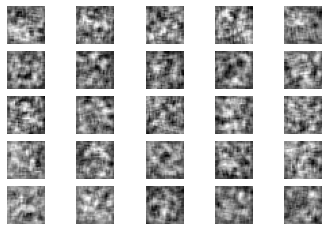

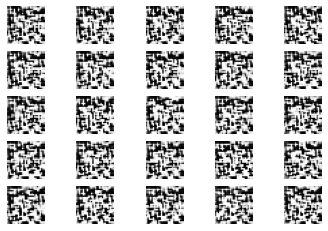

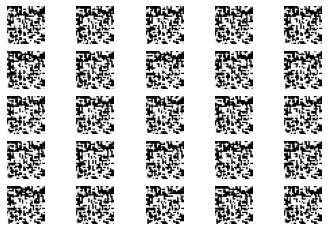

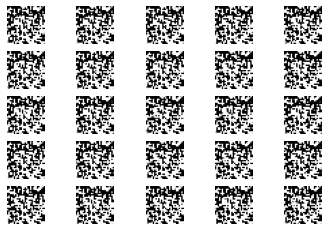

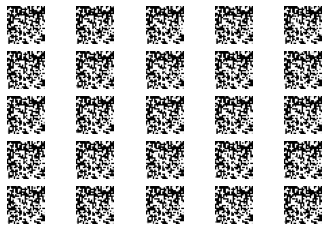

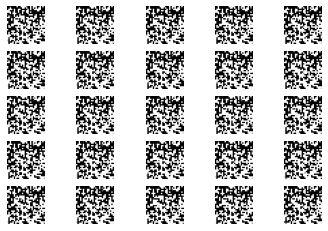

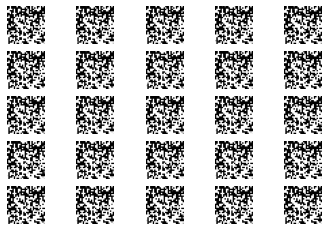

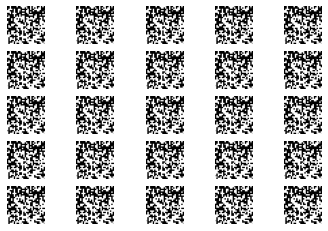

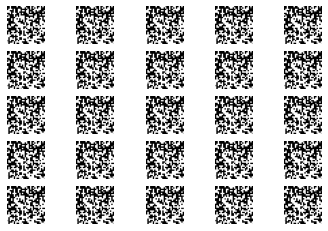

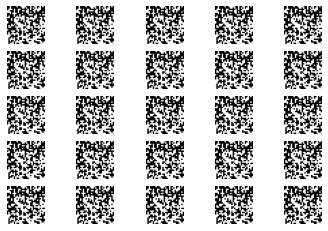

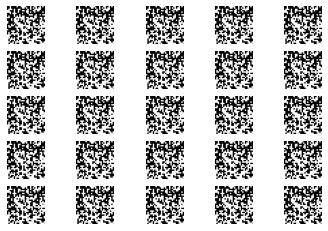

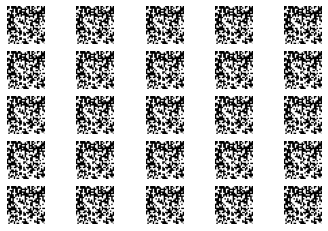

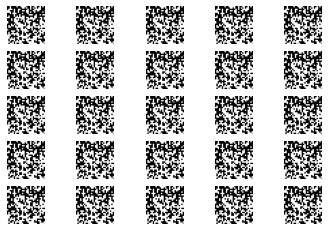

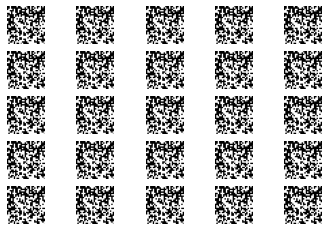

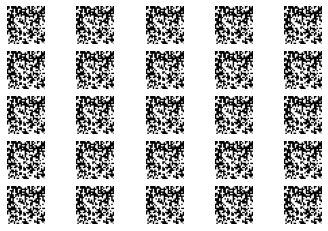

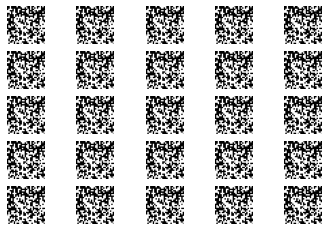

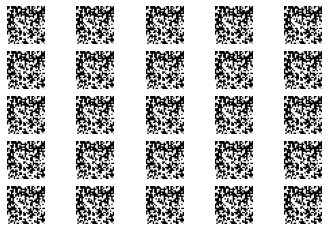

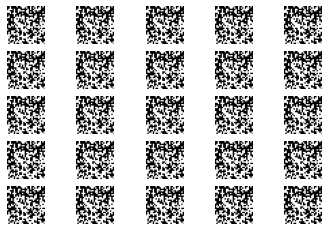

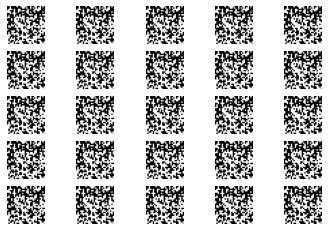

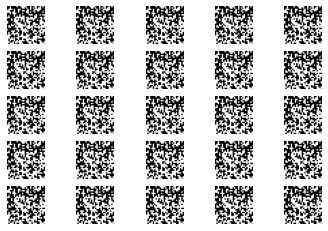

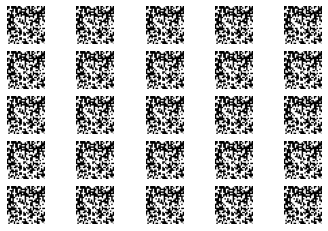

In [22]:
gan_train(4001, 32, 200)